In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS                                                                                 
from statsmodels.tools import add_constant

In [173]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted

class RegressRobustH(BaseEstimator, RegressorMixin):
    def __init__(self, fit_intercept=True, max_iter=10000, 
            initialbeta=None, initialgamma=None, tol=1e-8):
        self.fit_intercept = fit_intercept
        self.initialbeta = initialbeta
        self.initialgamma = initialgamma
        self.max_iter = max_iter
        self.tol = tol

    def _estimate_gamma(self, X, y, Z):
        """ Estimate gamma for the parametric weight"""
        reg = LinearRegression(fit_intercept=self.fit_intercept)
        reg_result0 = reg.fit(X, y)
        self._n_params = reg_result0.n_features_in_ + int(self.fit_intercept)
        # since ._validate_data() has been performed by sklearn estimator,
        # length for response (n_samples, ) has been checked to match with
        # regressor (n_samples, n_features), so:
        self._n_samples = len(y)
        residual = y - reg_result0.predict(X)
        sigma2 = \
            residual.T @ residual / (self._n_samples - self._n_params) # estimate of variance
        # initial estimate of gamma, using Z and 
        #
        response_gamma0 = \
            self._n_samples * np.square(residual) / np.sum(np.square(residual)) - 1
        # Shape of Z (n_samples, n_heteroscedastic_features)
        # will also be verified by sklearn estimator to match with 
        # response y (n_samples, )
        reg_gamma = reg.fit(Z, response_gamma0)
        if self.fit_intercept:
            return reg_gamma.intercept_, reg_gamma.coef_
        return reg_gamma.coef_

    def _weighted_regressor(self, X, y, Z, gamma):
        if self.fit_intercept:
            zgamma = (np.c_[np.repeat(1, self._n_samples), Z] @ gamma.T).flatten()
        else:
            zgamma = (Z @ gamma.T).flatten()
        expzgamma = np.exp(zgamma)
        weight = np.power((1 + expzgamma), -1)
        reg = self._reg.fit(X, y, sample_weight=weight)
        # checking fitted data porperties
        if not self._n_params:
            self._n_params = reg.n_features_in_ + int(self.fit_intercept)
        if not self._n_samples:
            self._n_samples = len(y)
        return reg
    
    def _scoring(self, X, y, Z, fitted_regressor, gamma):
        if self.fit_intercept:
            zgamma = (np.c_[np.repeat(1, self._n_samples), Z] @ gamma.T).flatten()
        else:
            zgamma = (Z @ gamma.T).flatten()
        y_predict = fitted_regressor.predict(X)
        expzgamma = np.exp(zgamma)
        weight = np.power((1 + expzgamma), -1)
        sqrtweight = np.sqrt(weight)
        weighted_res2 = np.square(sqrtweight * (y - y_predict))
        sigma2 = np.sum(weighted_res2) / (self._n_samples - self._n_params)
        q = expzgamma / (1 + expzgamma)
        zq = Z * q.reshape(-1, 1)
        res2 = np.square(y - y_predict)
        yq = res2 / (sigma2 * (1 + expzgamma)) - 1
        reg_q = self._reg.fit(zq, yq)
        if self.fit_intercept:
            gamma_q = np.c_[reg_q.intercept_, reg_q.coef_]
        else:
            gamma_q = reg_q.coef_
        return gamma_q

    def fit(self, X, y, Z):
        # since we wrap sklearn function, ._validate_data() will be
        # performed under sklearn estimator
        self._n_params = None
        self._n_samples = None
        self._reg = LinearRegression(fit_intercept=self.fit_intercept)
        if self.initialgamma:
            gamma = self.initialgamma
        else:
            if self.fit_intercept:
                gamma_intercept, gamma_coef = self._estimate_gamma(X, y, Z)
                gamma = np.c_[gamma_intercept, gamma_coef]
            else:
                gamma = self._estimate_gamma(X, y, Z)                                                                                                 
        gamma_arr = gamma.reshape(1, Z.shape[1] + int(self.fit_intercept))
        reg_result_arr = np.array([self._weighted_regressor(X, y, Z, gamma)]).reshape(-1, 1)
        if self.fit_intercept:
            reg_params_arr = \
                np.c_[[reg_result_arr[0, 0].intercept_], reg_result_arr[0, 0].coef_]\
                    .reshape(1, self._n_params)
        else:
            reg_params_arr = reg_result_arr[0, 0].coef_.reshape(1, self._n_params)
        d_arr = np.c_[reg_params_arr, gamma_arr]
        delta = 1
        # initiate iter k + 1 until tolerance satisfied
        # or max_iter excedeed  
        for i in range(self.max_iter):
            gamma_q = \
                self._scoring(X, y, Z, reg_result_arr[i, 0], gamma_arr[i])\
                    .reshape(1, Z.shape[1] + int(self.fit_intercept))
            gamma_new = (gamma_arr[i] + delta * gamma_q[0])\
                .reshape(1, Z.shape[1] + int(self.fit_intercept))
            gamma_arr = np.r_[gamma_arr, gamma_new]
            reg_new = np.array([
                self._weighted_regressor(X, y, Z, gamma_arr[i + 1])
                ]).reshape(-1, 1)
            if self.fit_intercept:
                reg_params_new = np.c_[
                    [reg_new[0, 0].intercept_], reg_new[0, 0].coef_
                ].reshape(1, self._n_params)
            else:
                reg_params_new = reg_new[0, 0].coef_.reshape(1, self._n_params)
            d_new = np.c_[reg_params_new, gamma_new]
            reg_result_arr = np.r_[reg_result_arr, reg_new]
            reg_params_arr = np.r_[reg_params_arr, reg_params_new]
            d_arr = np.r_[d_arr, d_new]
            # distance is ||d_new - d||^2 / ||d||^2 < tol
            tol = np.sum(np.square(d_arr[i + 1] - d_arr[i])) / np.sum(np.square(d_arr[i]))
            if tol < self.tol:
                break
        # Final converged parameter
        gamma = gamma_arr[-1]
        if self.fit_intercept:
            zgamma = (np.c_[np.repeat(1, self._n_samples), Z] @ gamma.T).flatten()
        else:
            zgamma = (Z @ gamma.T).flatten()   
        expzgamma = np.exp(zgamma)
        weight = np.power((1 + expzgamma), -1) 
        self._reg_result = reg_result_arr[-1, 0]
        self.coef_ = self._reg_result.coef_
        self.intercept_ = self._reg_result.intercept_
        self.n_features_in_ = self._reg_result.n_features_in_
        try:
            self.feature_names_in_ = self._reg_result.feature_names_in_
        except AttributeError:
            pass
        self.gamma_ = gamma_arr
        self.weight_ = weight
        self.n_iter_ = iter
        return self      

    def predict(self, X):
        check_is_fitted(self)
        return self._reg_result.predict(X)

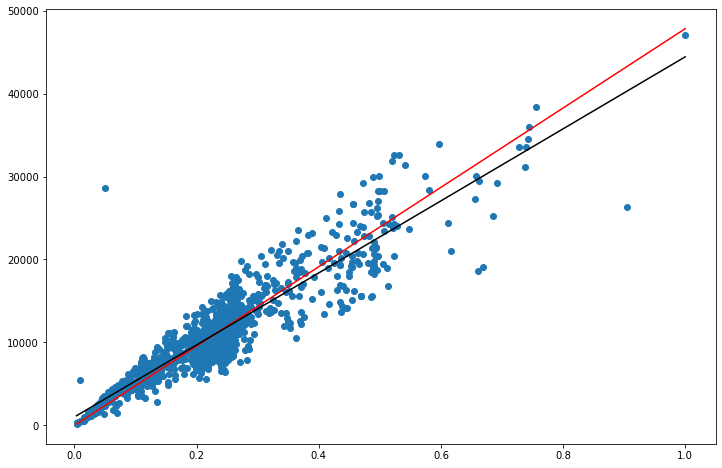

In [174]:
import matplotlib.pyplot as plt

trade_df = pd.read_csv('TradeH.csv', sep='\t', header=None, names=['quantity', 'value'])
X = trade_df['quantity'].values.reshape(-1, 1)
y = trade_df['value'].values
X = X / np.max(X)

reg = LinearRegression()
reg_result = reg.fit(X, y)

reg_H = RegressRobustH(max_iter=10000, fit_intercept=False)
reg_H_result = reg_H.fit(X, y, X)


fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(x=X, y=y)
ax.plot(np.sort(X.flatten()), reg_H_result.predict(X)[np.argsort(X.flatten())], color='red')
ax.plot(np.sort(X.flatten()), reg_result.predict(X)[np.argsort(X.flatten())], color='black')

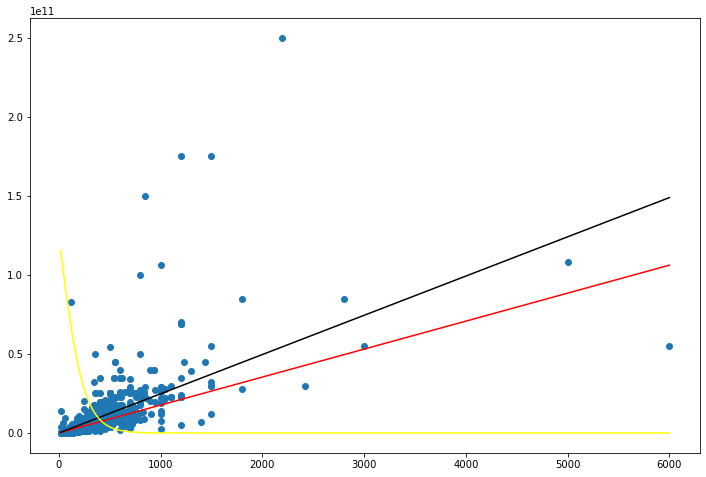

In [176]:
X_df = pd.read_csv('X_train.csv')
y_df = pd.read_csv('y_train.csv')

X = X_df['building_size_m2'].values.reshape(-1, 1)
y = y_df['price_in_rp'].values

reg = LinearRegression(fit_intercept=False)
reg_result = reg.fit(X, y)


reg_H = RegressRobustH(max_iter=10000, fit_intercept=False)
reg_H_result = reg_H.fit(X, y, X)


fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(x=X, y=y)
weighted_y = reg_H_result.weight_ * 2.5e11
ax.plot(np.sort(X.flatten()), reg_H_result.predict(X)[np.argsort(X.flatten())], color='red')
ax.plot(np.sort(X.flatten()), reg_result.predict(X)[np.argsort(X.flatten())], color='black')
ax.plot(np.sort(X.flatten()), weighted_y[np.argsort(X.flatten())], color='yellow')
